<font face="Times New Roman" size=5>
<div dir=rtl align="center">
<font face="Times New Roman" size=5>
In The Name of God
</font>
<br>
<img src="https://logoyar.com/content/wp-content/uploads/2021/04/sharif-university-logo.png" alt="University Logo" width="150" height="150">
<br>
<font face="Times New Roman" size=4 align=center>
Sharif University of Technology - Department of Electrical Engineering
</font>
<br>
<font color="#008080" size=6>
Deep Generative Models
</font>

<hr/>
<font color="#800080" size=5>
Assignment 2: Variational Autoencoders
<br>
</font>
<font size=5>
Instructor: Dr. S. Amini
<br>
</font>
<font size=4>
Fall 2024
<br>
</font>
<font face="Times New Roman" size=4>
Deadline: Month day at 23:55
</font>
<hr>
</div></font>

In [1]:
name = 'Fateme Raeijian'
std_id = '402203389'

In [2]:
! pip install numpy tqdm matplotlib torch torchvision

  Using cached matplotlib-3.9.2-cp312-cp312-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached contourpy-1.3.0-cp312-cp312-macosx_11_0_arm64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.54.1-cp312-cp312-macosx_11_0_arm64.whl.metadata (163 kB)
  Using cached kiwisolver-1.4.7-cp312-cp312-macosx_11_0_arm64.whl.metadata (6.3 kB)
  Using cached pillow-11.0.0-cp312-cp312-macosx_11_0_arm64.whl.metadata (9.1 kB)
  Using cached pyparsing-3.2.0-py3-none-any.whl.metadata (5.0 kB)
  Using cached filelock-3.16.1-py3-none-any.whl.metadata (2.9 kB)
  Using cached typing_extensions-4.12.2-py3-none-any.whl.metadata (3.0 kB)
  Using cached jinja2-3.1.4-py3-none-any.whl.metadata (2.6 kB)
  Using cached setuptools-75.3.0-py3-none-any.whl.metadata (6.9 kB)
  Using cached sympy-1.13.1-py3-none-any.whl.metadata (12 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 798

In [3]:
import numpy as np
from tqdm import trange
from matplotlib import pyplot as plt

import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, ConcatDataset

In [4]:
# Get cpu, gpu or mps device for training.
device = ("cuda" if torch.cuda.is_available()
          else "mps" if torch.backends.mps.is_available()
          else "cpu")
print(f"Using {device} device")

Using mps device


# Dataset (5 points)

Download the MNIST dataset and merge the train and test datasets for training the generative model.

In [12]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor()
])

# Load train and test datasets
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

Merge the two datasets to train the model on the images.

In [13]:
# Concatenate train and test datasets
merged_dataset = ConcatDataset([train_dataset, test_dataset])
merged_loader = DataLoader(merged_dataset, batch_size=128, shuffle=True)

print(f'The size of the merged dataset is {len(merged_loader.dataset)}')

The size of the merged dataset is 70000


# EDA (10 points)

Plot the distribution of each class in the dataset.

In [14]:
def plot_class_distribution(dataloader):
    # Initialize a dictionary to count occurrences of each class
    class_counts = {i: 0 for i in range(10)}
    
    # Iterate through the DataLoader to count the labels
    for _, labels in dataloader:
        for label in labels:
            class_counts[label.item()] += 1
    
    # Plot the histogram
    classes = list(class_counts.keys())
    counts = list(class_counts.values())
    plt.bar(classes, counts)
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.title('Class Distribution in Dataset')
    plt.show()

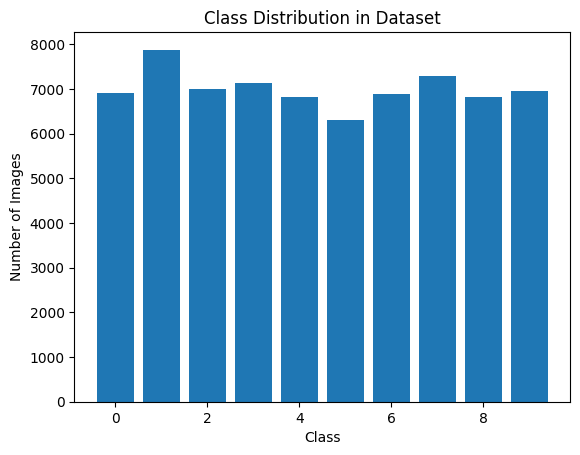

In [15]:
plot_class_distribution(merged_loader)

Plot the average of each class in the dataset.

In [16]:
def plot_class_averages(dataloader):
    # Initialize sums and counts for each class
    sums = {i: torch.zeros(28, 28) for i in range(10)}
    counts = {i: 0 for i in range(10)}
    
    # Iterate over the DataLoader to accumulate sums and counts
    for images, labels in dataloader:
        for img, label in zip(images, labels):
            sums[label.item()] += img.squeeze(0)
            counts[label.item()] += 1
    
    # Calculate the average images for each class
    averages = {i: sums[i] / counts[i] for i in range(10)}
    
    # Plot the averages
    fig, axes = plt.subplots(1, 10, figsize=(15, 2))
    for i in range(10):
        axes[i].imshow(averages[i], cmap='gray')
        axes[i].set_title(f'Class {i}')
        axes[i].axis('off')
    plt.show()

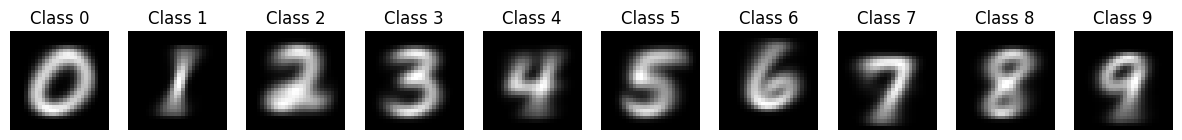

In [17]:
plot_class_averages(merged_loader)

# Variational Autoencoder (25 points)

In [18]:
class VAE(nn.Module):
    
    def __init__(self, latent_dim=2):
        super(VAE, self).__init__()
        # Encoder layers
        self.enc_fc1 = nn.Linear(28 * 28, 400)
        self.enc_fc2_mean = nn.Linear(400, latent_dim)
        self.enc_fc2_logvar = nn.Linear(400, latent_dim)
        
        # Decoder layers
        self.dec_fc1 = nn.Linear(latent_dim, 400)
        self.dec_fc2 = nn.Linear(400, 28 * 28)
        
    def encode(self, x):
        h = torch.relu(self.enc_fc1(x))
        mean = self.enc_fc2_mean(h)
        log_var = self.enc_fc2_logvar(h)
        return mean, log_var
    
    def reparameterization(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mean + eps * std
    
    def decode(self, z):
        h = torch.relu(self.dec_fc1(z))
        x_hat = torch.sigmoid(self.dec_fc2(h))
        return x_hat
    
    def forward(self, x):
        x = x.view(-1, 28 * 28)
        mean, log_var = self.encode(x)
        z = self.reparameterization(mean, log_var)
        x_hat = self.decode(z)
        return x_hat, mean, log_var

In [19]:
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
losses = []

# Training (20 points)

Define the loss function for training the VAE. The loss functions should be a combination of the reconstruction loss and the KL-divergence loss. You can choose to increase the weight of these losses to achieve better results.

In [20]:
def loss_function(x, x_hat, mean, log_var):
    # Reconstruction loss
    recon_loss = nn.functional.binary_cross_entropy(x_hat, x.view(-1, 28 * 28), reduction='sum')
    # KL divergence loss
    kl_loss = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return recon_loss + kl_loss

Now you must train your network using the loss function you defined earlier. Make sure to plot and monitor the training loss over epochs.

In [21]:
def plot_losses(losses):
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Time')
    plt.show()

def train(model, optimizer, n_epochs=50, losses=losses):
    model.train()
    for epoch in range(n_epochs):
        train_loss = 0
        for batch_idx, (data, _) in enumerate(merged_loader):
            data = data.to(device)
            optimizer.zero_grad()
            x_hat, mean, log_var = model(data)
            loss = loss_function(data, x_hat, mean, log_var)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        avg_loss = train_loss / len(merged_loader.dataset)
        print(f'Epoch {epoch+1}, Loss: {avg_loss}')
        losses.append(avg_loss)
    return losses

In [22]:
losses += train(model, optimizer)

Epoch 1, Loss: 188.39395072544642
Epoch 2, Loss: 166.438201171875
Epoch 3, Loss: 162.31144617745537
Epoch 4, Loss: 159.7925245814732
Epoch 5, Loss: 157.86890990513393
Epoch 6, Loss: 156.4210314453125
Epoch 7, Loss: 155.27474246651786
Epoch 8, Loss: 154.28792533482144
Epoch 9, Loss: 153.4833695033482
Epoch 10, Loss: 152.79530558035714
Epoch 11, Loss: 152.15263077566965
Epoch 12, Loss: 151.62878814174107
Epoch 13, Loss: 151.13249282924107
Epoch 14, Loss: 150.6593144810268
Epoch 15, Loss: 150.22520041852678
Epoch 16, Loss: 149.86393582589287
Epoch 17, Loss: 149.53241644810268
Epoch 18, Loss: 149.09012315848213
Epoch 19, Loss: 148.84013701171875
Epoch 20, Loss: 148.52766875
Epoch 21, Loss: 148.25228989955357
Epoch 22, Loss: 147.9777620954241
Epoch 23, Loss: 147.74913445870536
Epoch 24, Loss: 147.5213935825893
Epoch 25, Loss: 147.30223342633928
Epoch 26, Loss: 147.04032977120536
Epoch 27, Loss: 146.84432455357143
Epoch 28, Loss: 146.65622756696428
Epoch 29, Loss: 146.54194425223216
Epoch 30

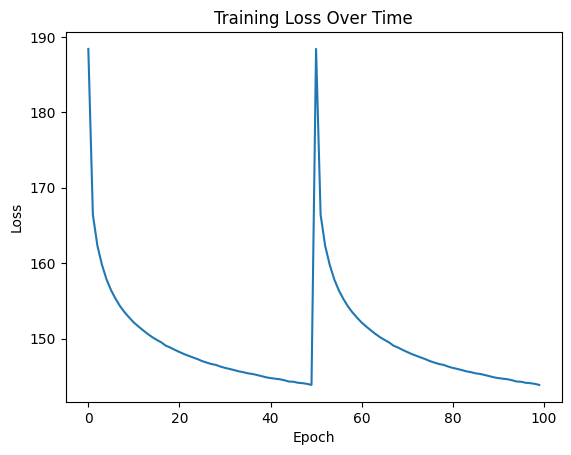

In [23]:
plot_losses(losses=losses)

# The Encoder (20 points)

Let's first take a look at the encoder. Start by visualizing the latent dimension for the merged dataset.

In [24]:
def visualize(vae, dataloader, batch_count=30, title='Latent Space Visualization'):
    vae.eval()
    latents = []
    labels_list = []
    with torch.no_grad():
        for i, (data, labels) in enumerate(dataloader):
            data = data.to(device)
            mean, log_var = vae.encode(data.view(-1, 28 * 28))
            z = vae.reparameterization(mean, log_var)
            latents.append(z.cpu().numpy())
            labels_list.append(labels.numpy())
            if i >= batch_count:
                break
    latents = np.concatenate(latents)
    labels_list = np.concatenate(labels_list)
    plt.figure(figsize=(8, 6))
    plt.scatter(latents[:, 0], latents[:, 1], c=labels_list, cmap='tab10')
    plt.colorbar()
    plt.title(title)
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.show()

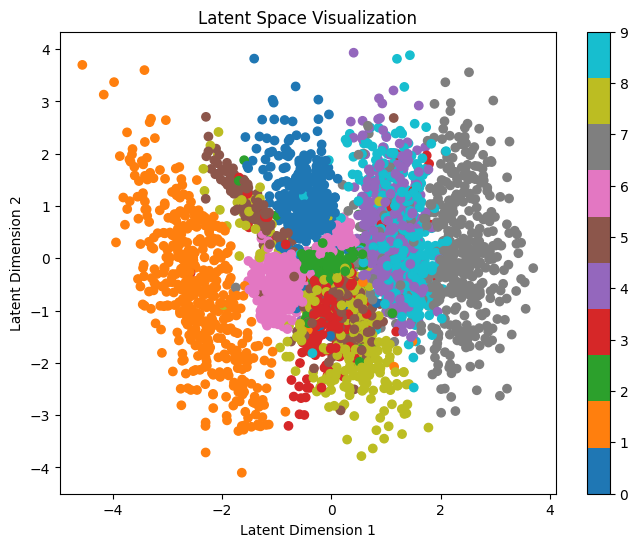

In [25]:
visualize(model, merged_loader)

Imagine if the input data for the encoder followed a very different distribution. Invert the images in the original datset and plot the latent dimension once more to show the difference.

In [27]:
def inverted_visualize(vae, dataloader, batch_count=30, title='Inverted Latent Space Visualization'):
    vae.eval()
    latents = []
    labels_list = []
    with torch.no_grad():
        for i, (data, labels) in enumerate(dataloader):
            data = 1 - data  # Invert the images
            data = data.to(device)
            mean, log_var = vae.encode(data.view(-1, 28 * 28))
            z = vae.reparameterization(mean, log_var)
            latents.append(z.cpu().numpy())
            labels_list.append(labels.numpy())
            if i >= batch_count:
                break
    latents = np.concatenate(latents)
    labels_list = np.concatenate(labels_list)
    plt.figure(figsize=(8, 6))
    plt.scatter(latents[:, 0], latents[:, 1], c=labels_list, cmap='tab10')
    plt.colorbar()
    plt.title(title)
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.show()

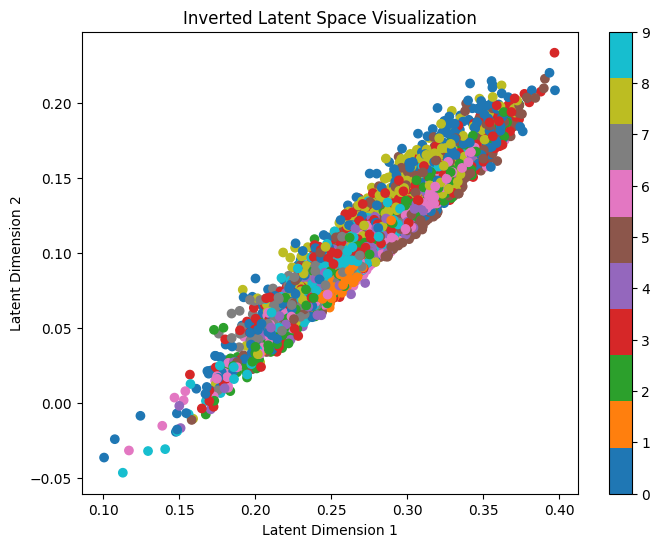

In [28]:
inverted_visualize(model, merged_loader)

Explain how the difference in the latent dimension allows us to detect data samples that don't follow the original distribution. How can this difference be used for anomaly detection? If we had used an autoencoder instead, what would be our observation then?

*`Your Answer:`*

# The Decoder (20 points)

In this section we are going to test the properties of the decoder. First implement a function to create samples based on the input mean and variance.

In [29]:
def generate_digit(mean, var):
    z = mean + torch.randn_like(mean) * torch.exp(0.5 * var)
    generated = model.decode(z)
    return generated

Now using this function plot the decoded output sampled from a uniform distribution from -1 to +1.

In [30]:
def plot_latent_space(model, scale=1.0, n=25, digit_size=28, figsize=15):
    figure = np.zeros((digit_size * n, digit_size * n))
    # Linearly spaced coordinates corresponding to the 2D latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    model.eval()
    with torch.no_grad():
        for i, yi in enumerate(grid_y):
            for j, xi in enumerate(grid_x):
                z_sample = torch.tensor([[xi, yi]]).float().to(device)
                x_decoded = model.decode(z_sample)
                digit = x_decoded.view(digit_size, digit_size).cpu().numpy()
                figure[i * digit_size: (i + 1) * digit_size,
                       j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.imshow(figure, cmap='gray')
    plt.axis('Off')
    plt.show()

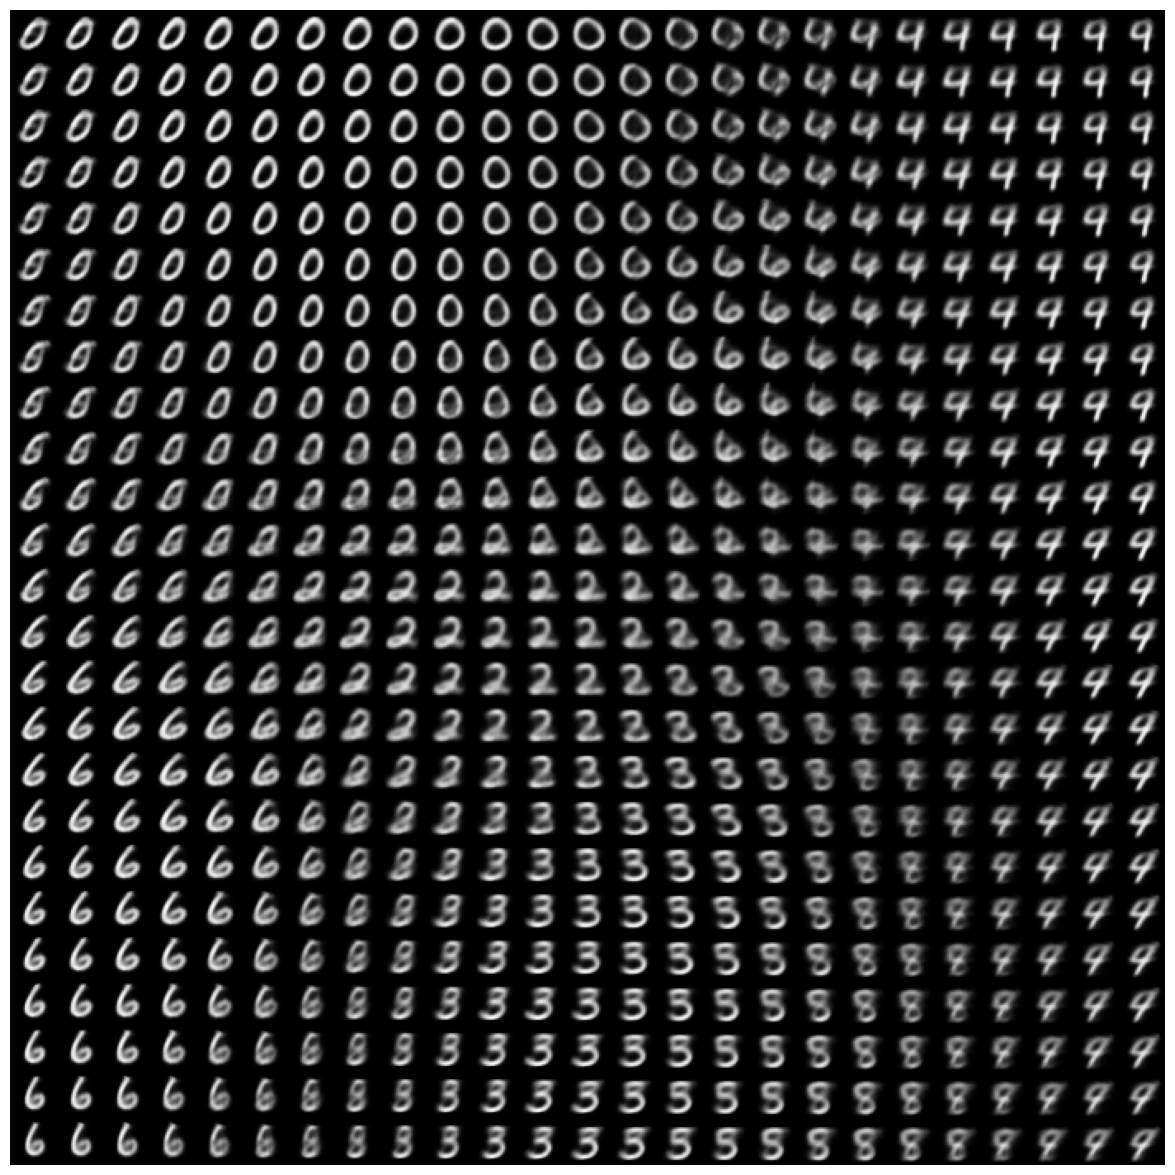

In [31]:
plot_latent_space(model)

What happens when you sample from regions outside the aformentioned space? Why? What could we expect if the network was not a variational autoencoder, but a simple autoencoder instead?

*`Your Answer:`*

When we sample from regions outside the aforementioned latent space (the range of latent variables corresponding to the training data), the generated images tend to become less coherent and may not resemble any recognizable digits. This occurs because the VAE has learned a latent space that captures the distribution of the training data, typically centered around the origin due to the prior distribution (usually a standard normal distribution). Sampling far from this learned manifold means the decoder receives inputs it hasn’t been trained on, leading to outputs that are essentially extrapolations rather than interpolations of the training data.

This behavior is crucial for anomaly detection. By observing how new data maps into the latent space, we can identify samples that fall outside the learned distribution, indicating they may be anomalies or outliers. If a data point maps to a region in the latent space where the VAE was not trained (e.g., the inverted images), it suggests that the data does not conform to the expected patterns learned from the training set.

If we had used a simple autoencoder instead of a variational autoencoder, the latent space would not have a well-defined structure or distribution. Simple autoencoders do not enforce any prior on the latent variables, resulting in an unordered and possibly discontinuous latent space. Consequently, sampling from random points in the latent space of a simple autoencoder is unlikely to produce meaningful outputs, as the decoder hasn’t learned to generate data from those arbitrary points. Moreover, the lack of a probabilistic framework makes it less suitable for tasks like anomaly detection, where understanding the data distribution is essential.